In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, VotingRegressor

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [5]:
# Параметры отображения датафреймов:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 25)

In [6]:
# Параметры отображения графиков:
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams.update({'font.size': 11})

# Загрузка и обработка исходных данных

In [7]:
# Ссылка на csv-файл с данными:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00560/SeoulBikeData.csv'

Исходный файл в заголовках столбцов таблицы содержит символы, которые некорректно считываются при парсинге. Поэтому считываем только данные и добавляем новые заголовки столбцов. Одновременно преобразуем часть столбцов в категорийные, столбец с датами - в формат datetime.

In [8]:
# Новый список заголовков:
cols = ['date', 'n_bikes', 'hour', 'temperature', 'humidity', 'windspeed', 'visibility',
        'dew_point_temp', 'solar_radiation', 'rainfall', 'snowfall', 'season', 'holiday', 'func_day']

In [9]:
# Категорийные столбцы:
dtypes = {'season': 'category', 'holiday': 'category', 'func_day': 'category'}

In [10]:
# Считываем данные:
data = pd.read_csv(url, skiprows=1, header=None, names=cols, parse_dates=['date'], dtype=dtypes)

In [11]:
# Типы данных:
data.shape

(8760, 14)

In [12]:
data.dtypes

date               datetime64[ns]
n_bikes                     int64
hour                        int64
temperature               float64
humidity                    int64
windspeed                 float64
visibility                  int64
dew_point_temp            float64
solar_radiation           float64
rainfall                  float64
snowfall                  float64
season                   category
holiday                  category
func_day                 category
dtype: object

In [13]:
data.head()

,date,n_bikes,hour,temperature,humidity,windspeed,visibility,dew_point_temp,solar_radiation,rainfall,snowfall,season,holiday,func_day
0,2017-01-12,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,2017-01-12,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2017-01-12,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,2017-01-12,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,2017-01-12,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [14]:
# Проверяем наличие пропусков в данных:
data.isna().sum()

date               0
n_bikes            0
hour               0
temperature        0
humidity           0
windspeed          0
visibility         0
dew_point_temp     0
solar_radiation    0
rainfall           0
snowfall           0
season             0
holiday            0
func_day           0
dtype: int64

In [15]:
# Добавляем столбец с номером года:
data['year'] = data['date'].dt.year

In [16]:
# Добавляем столбец с номером месяца:
data['month'] = data['date'].dt.month

In [17]:
# Сводные ежедневные данные:
daily_data = data.groupby('date')['n_bikes'].sum().reset_index()

# Визуализация данных

Text(0.5, 1.0, 'Динамика спроса на аренду велосипедов')

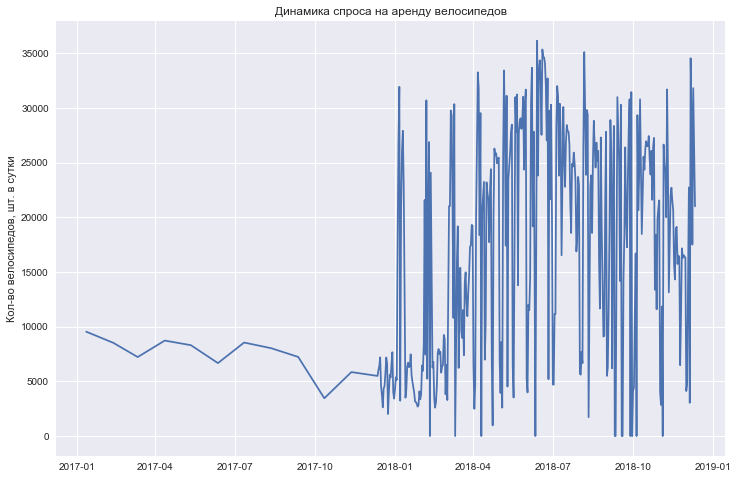

In [18]:
plt.plot(daily_data['date'], daily_data['n_bikes'])
plt.ylabel('Кол-во велосипедов, шт. в сутки')
plt.title('Динамика спроса на аренду велосипедов')

Из графика с динамикой числа аредованных велосипедов видно, что период до декабря 2017 года принципиально отличается по тренду и амплитуде колебаний рассматриваемого показателя от последующего периода.

Text(0.5, 0.98, 'Распределение значений параметров')

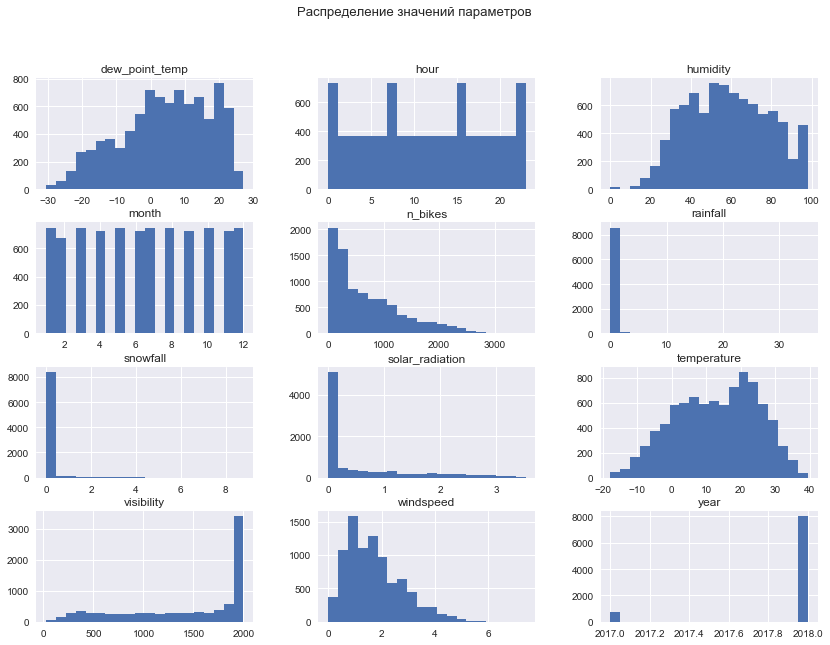

In [19]:
data.hist(bins=20, figsize=(14, 10));
plt.suptitle('Распределение значений параметров')

Анализ гистограмм распределения параметров показывает, что количество данных за 2017 год в несколько раз меньше, чем за 2018 год. То есть до декабря 2017 года данные представлены не за все периоды.

In [20]:
# Количество данных, приходящихся на 2017 и 2018 год:
data['year'].value_counts()

2018    8016
2017     744
Name: year, dtype: int64

In [21]:
# Для дальнейшего анализа берем данные с декабря 2017 года:
data = data[data['date'] > '2017-12']

In [22]:
# Средние данные по времени суток:
hourly_average = data.groupby('hour')['n_bikes'].mean().reset_index()

Text(0.5, 1.0, 'Изменение спроса с течение дня')

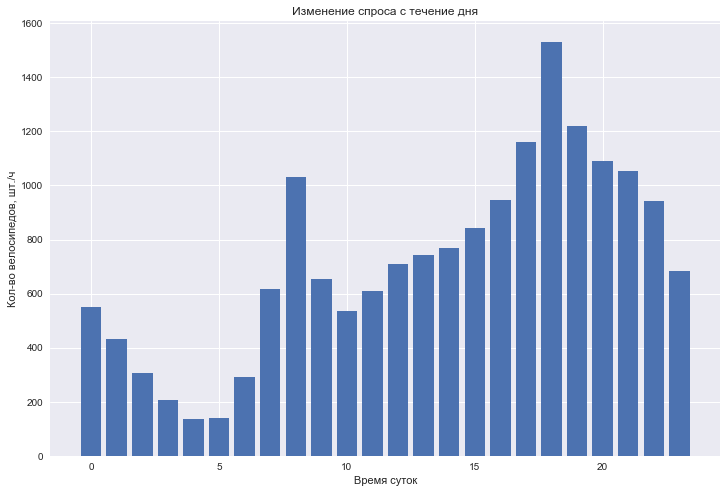

In [23]:
plt.bar(hourly_average['hour'], hourly_average['n_bikes'])
plt.xlabel('Время суток')
plt.ylabel('Кол-во велосипедов, шт./ч')
plt.title('Изменение спроса с течение дня')

В течение суток прослеживается два явно выраженных пика спроса на аренду велосипедов: наиболее значительный - в вечерние часы (18.00 - в среднем около 1500 шт. в час) и менее значительный - в утренние (8.00 - чуть более 1000 шт. в час).

In [24]:
# Средние данные по месяцам:
monthly_average = data.groupby('month')['n_bikes'].mean().reset_index()

Text(0.5, 1.0, 'Изменение спроса в течение года')

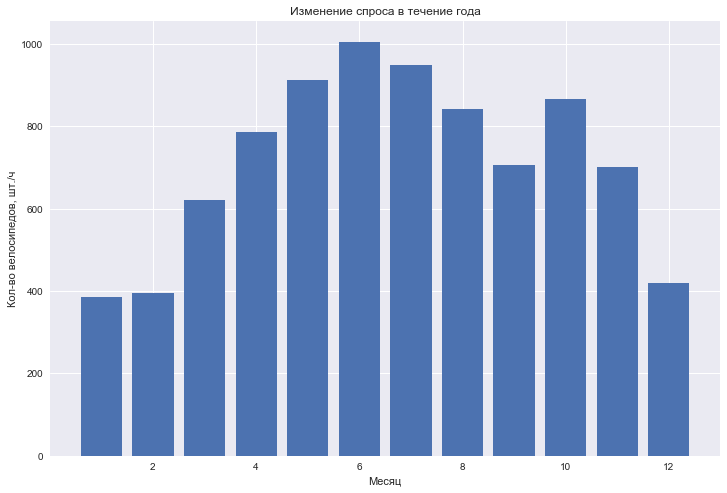

In [25]:
plt.bar(monthly_average['month'], monthly_average['n_bikes'])
plt.xlabel('Месяц')
plt.ylabel('Кол-во велосипедов, шт./ч')
plt.title('Изменение спроса в течение года')

В течение года пик спроса на велосипеды приходится на июнь (в среднем около 1000 шт. в час). В октябре также происходит увеличение спроса (в среднем до 850 шт. в час). Наименьший спрос приходится на зимние месяцы (в среднем около 400 шт. в час).

In [26]:
# Начало временного ряда:
data['date'].min()

Timestamp('2017-12-12 00:00:00')

In [27]:
# Окончание временного ряда:
data['date'].max()

Timestamp('2018-12-11 00:00:00')

In [28]:
# Распределение спроса по сезонам:
seasonal_data = data.groupby('season')['n_bikes'].sum().reset_index()

Text(0.5, 1.0, 'Структура спроса по сезонам')

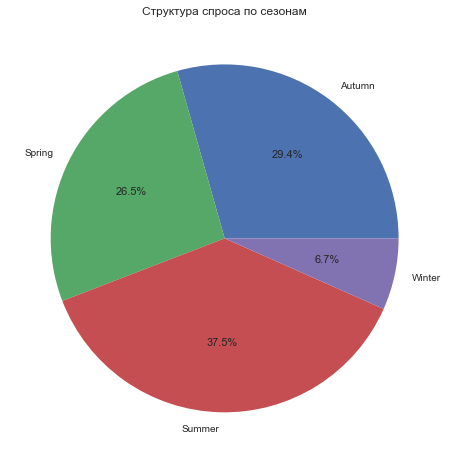

In [29]:
plt.pie(seasonal_data['n_bikes'], labels=seasonal_data['season'], autopct='%1.1f%%')
plt.title('Структура спроса по сезонам')

Наиболее значительный объем спроса приходится на летний период (37.5%), наименее значительный - на зимний (6.7%). В осенний период спрос чуть более активен, чем в весенний.

Text(0.5, 1, 'Матрица корреляции')

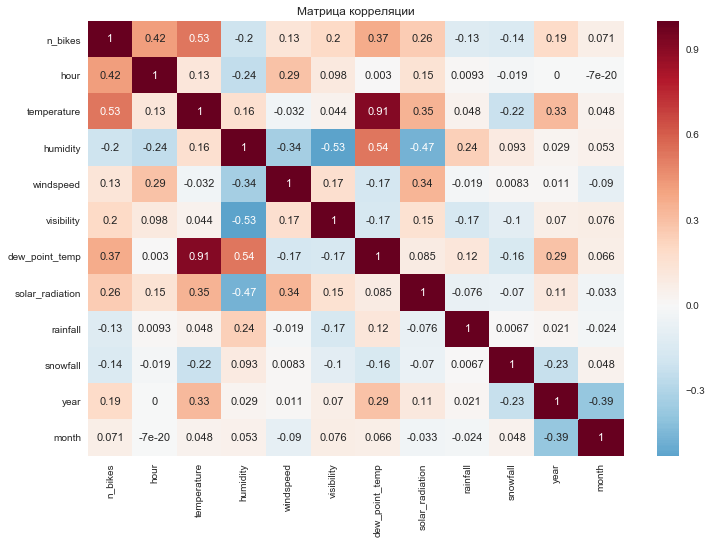

In [30]:
correlation = data.corr()
ax = sns.heatmap(correlation, center=0, annot=True, cmap='RdBu_r')
l, r = ax.get_ylim()
ax.set_ylim(l + 0.5, r - 0.5)
plt.yticks(rotation=0)
plt.title('Матрица корреляции')

#### Параметры с наиболее высокой корреляцией со спросом на аренду велосипедов:
- Температура воздуха
- Час суток
- Температура "точки росы"
- Солнечная радиация

# Подготовка данных для модели

In [31]:
# Прогнозируемые значения:
y = data.pop('n_bikes')

In [32]:
# Входные параметры для моделей:
X = data.select_dtypes(include=['number', 'category'])

In [33]:
# Составляем списки числовых и категорийных параметров:
num_cols = data.select_dtypes(include='number').columns
cat_cols = data.select_dtypes(include='category').columns

In [34]:
num_cols

Index(['hour', 'temperature', 'humidity', 'windspeed', 'visibility',
       'dew_point_temp', 'solar_radiation', 'rainfall', 'snowfall', 'year',
       'month'],
      dtype='object')

In [35]:
cat_cols

Index(['season', 'holiday', 'func_day'], dtype='object')

In [36]:
# Преобразование данных (кодирование категорийных столбцов,
# нормирование числовых значений):
ct = make_column_transformer(
    (OneHotEncoder(), cat_cols),
    (StandardScaler(), num_cols),
    remainder='passthrough')

In [37]:
# Нормирование данных:
X_processed = ct.fit_transform(X)

# Подбор модели

In [38]:
# Инструмент для разбиения данных на группы при кросс-валидации:
kf = KFold(10, shuffle=True)

In [39]:
# Список рассматриваемых моделей:
models = [('KNN', KNeighborsRegressor()),
          ('Decision Tree', DecisionTreeRegressor()),
          ('Gradient Boosting', GradientBoostingRegressor()),
          ('Random Forest', RandomForestRegressor(n_estimators=100))]

In [40]:
# Параметр R2 при кросс-валидации для рассматриваемых моделей:
for name, model in models:
    rmodel = model
    r2 = cross_val_score(rmodel, X_processed, y, cv=kf, scoring='r2').mean()
    print(f'{name}: R2 = {r2}')

KNN: R2 = 0.7906359080775422
Decision Tree: R2 = 0.7634230851528636
Gradient Boosting: R2 = 0.8449562859736066
Random Forest: R2 = 0.878704138513225


#### Регрессоры с наиболее высокой точностью:
- Random Forest
- Gradient Boosting

In [41]:
# Создадим ансамбль из двух алгоритмов регрессии:
r_1 = RandomForestRegressor(n_estimators=100)
r_2 = GradientBoostingRegressor()
model = VotingRegressor([('RF', r_1), ('GB', r_2)])

In [42]:
# Точночть прогнозов при кросс-валидации:
cross_val_score(model, X_processed, y, cv=kf, scoring='r2').mean()

0.8733412114143849

Полученный результат комбинированной модели сопоставим результатом модели Random Forest и не улучшил точность прогнозов.

Для улучшения модели целесообразно взять для обучения выборку данных за более продолжительный период времени (за несколько лет), чтобы сезонные колебания спроса и общий тренд учитывались более корректно. Однако в имеющемся датасете около половины от всех доступных данных не могут использоваться для анализа, т.к. принципиально отличаются по динамике от последующих значений.

In [43]:
# При отсутствии дополнительных данных пробуем улучшить
# точность модели подбором оптимальных гиперпараметров:
model = RandomForestRegressor()
params = {'n_estimators': [50, 70, 100, 120],
          'min_samples_split': [2, 3]}
grid = GridSearchCV(model, params, cv=kf, scoring='r2', n_jobs=-1, refit=True)
grid.fit(X_processed, y)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs

In [44]:
# Параметры оптимальной модели:
grid.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [45]:
# Точность оптимальной модели:
grid.best_score_

0.8803249330116183

По итогам кросс-валидации выбраны те же параметры модели RandomForestRegressor, которые заданы по умолчанию. Полученное незначительное увеличение точности при кросс-валидации может быть связано с особенностями разбиения данных на группы (параметр random_state не был задан).

С учетом качества и объема данных, используемых для обучения, созданная прогнозная модель может использоваться только для оценки спроса на аренду велосипедов в краткосрочной перспективе. Помимо сезонного фактора и времени суток, значимо влияющих на спрос, в качестве входных параметров используются детальные погодно-климатические условия, прогноз которых сам по себе имеет высокую степень погрешности. Поэтому наибольшую достоверность будут иметь прогнозы, составляемые не более чем на 2-3 дня вперед. С увеличением горизонта прогнозирования до 10 дней и более точность оценок будет резко снижаться.